## 03 - Geocentric Models

#### Imports

In [2]:
# ruff: noqa: F405
from init_notebook import *

%config InlineBackend.figure_formats = ['svg']

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

import seaborn as sns

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-02-05T11:17:43.631776+04:00

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.32.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

watermark  : 2.5.0
statsmodels: 0.14.4
xarray     : 2025.1.2
matplotlib : 3.10.0
pymc       : 5.20.0
arviz      : 0.20.0
scipy      : 1.15.1
numpy      : 1.26.4
seaborn    : 0.13.2
pandas     : 2.2.3



#### Introduction

**Linear regression** is the geocentric model of applied statistics. By “linear regression,” we will mean a family of simple statistical golems that attempt to learn about the mean and variance of some measurement, using an additive combination of other measurements. Like geocentrism, linear regression can usefully describe a very large variety of natural phenomena. Like geocentrism, linear regression is a descriptive model that corresponds to many different process models. If we read its structure too literally, we’re likely to make mistakes. But used wisely, these little linear golems continue to be useful.

This notebook introduces linear regression as a Bayesian procedure. Under a probability interpretation, which is necessary for Bayesian work, linear regression uses a Gaussian (normal) distribution to describe our model’s uncertainty about some measurement of interest. This type of model is simple, flexible, and commonplace. Like all statistical models, it is not universally useful. But linear regression has a strong claim to being foundational, in the sense that once you learn to build and interpret linear regression models, you can more easily move on to other types of regression which are less normal.

*Fourier series*, a way of decomposing a periodic function into a series of sine and cosine functions.

#### Why Normal Distributions are Normal

Suppose you and a thousand of your closest friends line up on the halfway line of a soccer field (football pitch). Each of you has a coin in your hand. At the sound of the whistle, you begin flipping the coins. Each time a coin comes up heads, that person moves one step towards the left-hand goal. Each time a coin comes up tails, that person moves one step towards the right-hand goal. Each person flips the coin 16 times, follows the implied moves, and then stands still. Now we measure the distance of each person from the halfway line. Can you predict what proportion of the thousand people who are standing on the halfway line? How about the proportion 5 yards left of the line?

It’s hard to say where any individual person will end up, but you can say with great confidence what the collection of positions will be. The **distances will be distributed in approximately normal, or Gaussian**, fashion. This is true even though the **underlying distribution is binomial**. It does this because there are so many more possible ways to realize a sequence of left-right steps that sums to zero. There are slightly fewer ways to realize a sequence that ends up one step left or right of zero, and so on, with the number of possible sequences declining in the characteristic bell curve of the normal distribution.

##### Normal by Addition

Let’s see this result, by simulating this experiment. To show that there’s nothing special about the underlying coin flip, assume instead that **each step is different from all the others**, a random distance between zero and one yard. Thus a coin is flipped, a distance between zero and one yard is taken in the indicated direction, and the process repeats. To simulate this, we generate for each person a list of 16 random numbers between −1 and 1. These are the individual steps. Then we add these steps together to get the position after 16 steps. Then we need to replicate this procedure 1000 times.

In [3]:
rng = np.random.default_rng(4567)

steps = 16
repetitions = 1_000

tosses = rng.uniform(-1,1,size=(steps,repetitions))
pos = np.zeros((steps+1, repetitions))
pos[1:,:] = np.cumsum(tosses, axis=0)   

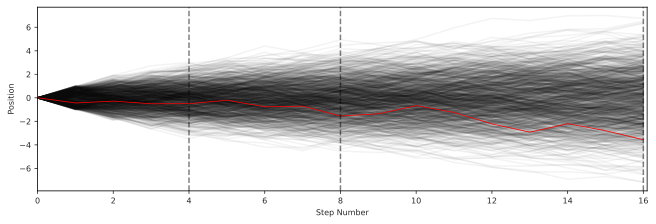

In [4]:
show_steps = [4,8,16]

plt.figure(figsize=(9,3))
plt.plot(np.arange(0,steps+1), pos, 'k',alpha=0.05)
plt.plot(range(0, steps + 1), pos[:, 5], c="r", linewidth=0.75)
plt.xlim(0,16.1)
plt.xlabel("Step Number")
plt.ylabel("Position")
plt.gca().spines[['right', 'top']].set_visible(True);

for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5);

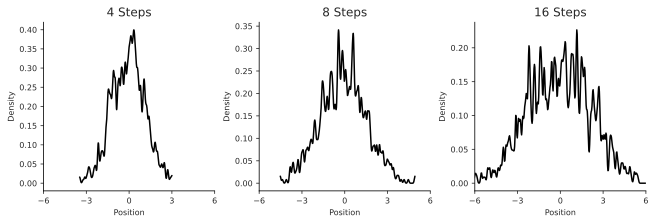

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

for step, ax in zip(show_steps, axs):
    az.plot_kde(pos[step,:], bw=0.05, ax=ax)
    ax.set_title(f"{step} Steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-6, -3, 0, 3, 6])

Random walks on the soccer field converge to a normal distribution. The more steps are taken, the closer the match between the real empirical distribution of positions and the ideal normal distribution.

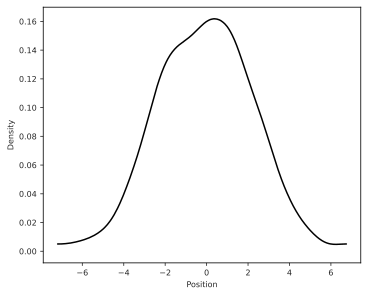

In [6]:
plt.figure(figsize=(5,4))
az.plot_kde(pos[-1])
plt.xlabel("Position")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

The results above show these random walks and how their distribution evolves as the number of steps increases. The top panel plots 100 different, independent random walks, with one highlighted in black. The vertical dashes indicate the locations corresponding to the distribution plots underneath, measured after 4, 8, and 16 steps. Although the distribution of positions starts off seemingly idiosyncratic, after 16 steps, it has already taken on a familiar outline. The familiar “bell” curve of the Gaussian distribution is emerging from the randomness. Go ahead and experiment with even larger numbers of steps to verify for yourself that the distribution of positions is stabilizing on the Gaussian. You can square the step sizes and transform them in a number of arbitrary ways, without changing the result: Normality emerges. Where does it come from?

**Any process that adds together random values from the same distribution converges to a normal**. But it’s not easy to grasp why addition should result in a bell curve of sums. Here’s a conceptual way to think of the process. **Whatever the average value of the source distribution, each sample from it can be thought of as a fluctuation from that average value**. When we begin to add these fluctuations together, they also begin to cancel one another out. A large positive fluctuation will cancel a large negative one. The more terms in the sum, the more chances for each fluctuation to be canceled by another, or by a series of smaller ones in the opposite direction. So eventually the most likely sum, in the sense that there are the most ways to realize it, will be a sum in which every fluctuation is canceled by another, a sum of zero (relative to the mean).

It doesn’t matter what shape the underlying distribution possesses. It could be uniform, like in our example above, or it could be (nearly) anything else. Depending upon the underlying distribution, the convergence might be slow, but it will be inevitable. Often, as in this example, convergence is rapid.

##### Normal by Multiplication

Here’s another way to get a normal distribution. Suppose the growth rate of an organism is influenced by a dozen loci, each with several alleles that code for more growth. Suppose also that all of these loci interact with one another, such that each increase growth by a percentage. This means that their effects multiply, rather than add. For example, we can sample a random growth rate for this example with this line of code:

In [7]:
growth = np.prod(1 + rng.uniform(0,0.1,size=(12,10_000)), axis=0)

This code just samples 12 random numbers between 1.0 and 1.1 for 10,000 runs, each representing a proportional increase in growth. Thus 1.0 means no additional growth and 1.1 means a 10% increase. The product of all 12 is computed and returned as output. Now what distribution do you think these random products will take?

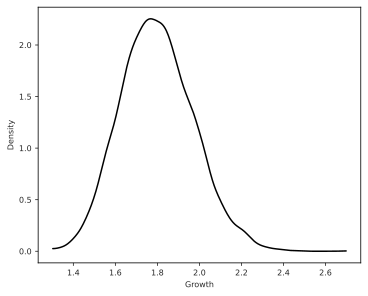

In [8]:
plt.figure(figsize=(5,4))
az.plot_kde(growth)
plt.xlabel("Growth")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

The distribution is approximately normal again. I said normal distributions arise from summing random fluctuations, which is true. But the effect at each locus was multiplied by the effects at all the others, not added. So what’s going on here?

We again get convergence towards a normal distribution, because the effect at each locus is quite small. Multiplying small numbers is approximately the same as addition. For example, if there are two loci with alleles increasing growth by 10% each, the product is:

$$1.1 \times 1.1 = 1.21$$

We could also approximate this product by just adding the increases, and be off by only 0.01:

$$1.1 \times 1.1 = (1 + 0.1)(1 + 0.1) = 1 + 0.2 + 0.01 \approx 1.2$$

The smaller the effect of each locus, the better this additive approximation will be. In this way, small effects that multiply together are approximately additive, and so they also tend to stabilize on Gaussian distributions. Verify this by comparing:

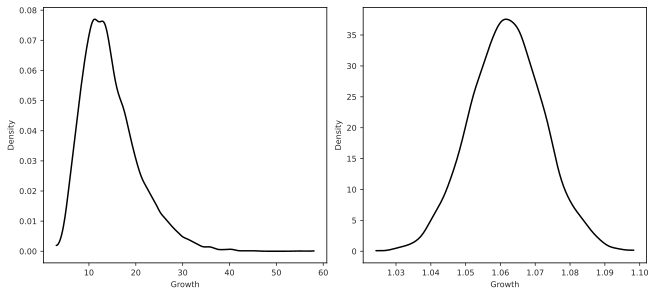

In [9]:
big = np.prod(1 + rng.uniform(0,0.5,size=(12,10_000)), axis=0)
small = np.prod(1 + rng.uniform(0,0.01,size=(12,10_000)), axis=0)

_, axs = plt.subplots(1, 2, figsize=(9, 4))
az.plot_kde(big, ax=axs[0])
az.plot_kde(small, ax=axs[1])
for ax in axs:
    ax.set(xlabel='Growth', ylabel='Density')
    ax.spines[['right', 'top']].set_visible(True);

The interacting growth deviations, as long as they are sufficiently small, converge to a Gaussian distribution. In this way, the range of causal forces that tend towards Gaussian distributions extends well beyond purely additive interactions.

##### Normal by Log-Multiplication

Large deviates that are multiplied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale. For example:

In [10]:
growth = np.log(np.prod(1 + rng.uniform(0,0.1,size=(12,10_000)), axis=0))

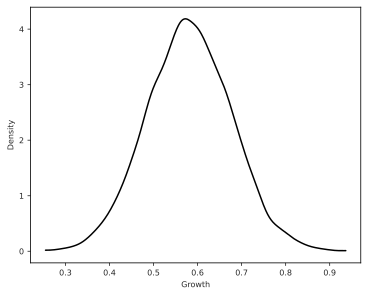

In [11]:
plt.figure(figsize=(5,4))
az.plot_kde(growth)
plt.xlabel("Growth")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

Yet another Gaussian distribution. We get the Gaussian distribution back, because adding logs is equivalent to multiplying the original numbers. So even **multiplicative interactions of large deviations can produce Gaussian distributions**, once we measure the outcomes on the log scale. Since **measurement scales are arbitrary**, there’s nothing suspicious about this transformation. After all, it’s natural to measure sound and earthquakes and even information on a log scale.

##### Using Gaussian Distributions

We’re going to spend the rest of this chapter using the Gaussian distribution as a skeleton for our hypotheses, building up **models of measurements as aggregations of normal distributions**. The justifications for using the Gaussian distribution fall into two broad categories: (1) **ontological** and (2) **epistemological**.

By the ontological justification, the world is full of Gaussian distributions, approximately. We’re never going to experience a perfect Gaussian distribution. But it is a widespread pattern, appearing again and again at different scales and in different domains. Measurement errors, variations in growth, and the velocities of molecules all tend towards Gaussian distributions. These processes do this because at their heart, these **processes add together fluctuations**. And repeatedly adding **finite fluctuations results in a distribution of sums that have shed all information about the underlying process, aside from mean and spread**.

One consequence of this is that statistical models based on Gaussian distributions cannot reliably identify micro-process. But it also means that these models can do useful work, even when they cannot identify process. If we had to know the development biology of height before we could build a statistical model of height, human biology would be sunk.

There are many other patterns in nature, so make no mistake in assuming that the Gaussian pattern is universal. Later, we’ll see how other useful and common patterns, like the **exponential** and **gamma** and **Poisson**, also arise from natural processes. The Gaussian is a member of a family of **fundamental natural distributions** known as the **exponential family**. All of the members of this family are important for working science, because they populate our world.

But the natural occurrence of the Gaussian distribution is only one reason to build models around it. By the epistemological justification, the Gaussian represents a particular state of ignorance. When all we know or are willing to say about a distribution of measures (measures are continuous values on the real number line) is their mean and variance, then the Gaussian distribution arises as the most consistent with our assumptions.

That is to say that the Gaussian distribution is the most natural expression of our state of ignorance, because if all we are willing to assume is that a measure has finite variance, the Gaussian distribution is the shape that can be realized in the largest number of ways and does not introduce any new assumptions. It is the least surprising and least informative assumption to make. In this way, the Gaussian is the distribution most consistent with our assumptions. If you don’t think the distribution should be Gaussian, then that implies that you know something else that should inform your model, something that would improve inference.

This epistemological justification is premised on **information theory** and **maximum entropy**. We’ll dwell on information theory and maximum entropy later. Then other common and useful distributions will be used to build generalized linear models (GLMs). When these other distributions are introduced, you’ll learn the constraints that make them the uniquely most appropriate distributions. 

For now, let’s take the ontological and epistemological justifications of just the Gaussian distribution as reasons to start building models of measures around it. Throughout all of this modeling, keep in mind that using a model is not equivalent to swearing an oath to it.

**Rethinking: Heavy tails**. The Gaussian distribution is common in nature and has some nice properties. But there are some risks in using it as a default data model. The extreme ends of a distribution are known as its tails. And the Gaussian distribution has some very thin tails—there is very little probability in them. Instead most of the mass in the Gaussian lies within one standard deviation of the mean. Many natural (and unnatural) processes have much heavier tails. These processes have much higher probabilities of producing extreme events. A real and important example is financial time series—the ups and downs of a stock market can look Gaussian in the short term, but over medium and long periods, extreme shocks make the Gaussian model (and anyone who uses it) look foolish. Historical time series may behave similarly, and any inference for example of trends in warfare is prone to heavy-tailed surprises.69 We’ll consider alternatives to the Gaussian later.

**Overthinking: Gaussian distribution**. You don’t have to memorize the Gaussian probability distribution. You’re computer already knows it. But some knowledge of its form can help demystify it. The probability density (see below) of some value $y$, given a Gaussian (normal) distribution with mean $μ$ and standard deviation $σ$, is:

$$p(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)$$

This looks monstrous. The important bit is just the $(y−\mu)^2$ bit. This is the part that gives the normal distribution its **fundamental quadratic shape**. Once you exponentiate the quadratic shape, you get the classic bell curve. The rest of it just scales and standardizes the distribution. 

The Gaussian is a **continuous distribution**, unlike the discrete distributions from earlier. Probability distributions with only discrete outcomes, like the binomial, are called **probability mass functions** and denoted $Pr$. Continuous ones like the Gaussian are called **probability density functions**, denoted with $p$ or just plain old $f$, depending upon author and tradition. For mathematical reasons, **probability densities can be greater than 1**. Try `stats.norm.pdf(0,0,0.1)`, for example, which is the way to calculate $p(0|0,0.1)$ in python. The answer, about 4, is no mistake. **Probability density is the rate of change in cumulative probability**. So where cumulative probability is increasing rapidly, density can easily exceed 1. But if we calculate the **area under the density function, it will never exceed 1**. Such areas are also called **probability mass**. You can usually ignore these density/mass details while doing computational work. But it’s good to be aware of the distinction. Sometimes the difference matters.

The Gaussian distribution is routinely seen without $σ$ but with another parameter, $τ$. The parameter $τ$ in this context is usually called **precision** and defined as $τ=1/σ^2$. When $σ$ is large, $τ$ is small. This change of parameters gives us the equivalent formula (just substitute $σ=1/\sqrt{τ}$):

$$p(y \mid \mu, \tau) = \sqrt{\frac{\tau}{2\pi}}exp\left(-\frac{1}{2}\tau(y-\mu)^2\right)$$

This form is common in Bayesian data analysis, and Bayesian model fitting software, such as BUGS or JAGS, sometimes requires using $τ$ rather than $σ$.


#### A Language for Describing Models

This book adopts a standard language for describing and coding statistical models. You find this language in many statistical texts and in nearly all statistical journals, as it is general to both Bayesian and non-Bayesian modeling. Scientists increasingly use this same language to describe their statistical methods, as well. So learning this language is an investment, no matter where you are headed next.

Here’s the approach, in abstract. There will be many examples later, but it is important to get the general recipe before seeing these.

1) First, we recognize a set of variables to work with. Some of these variables are observable. We call these **data**. Others are unobservable things like rates and averages. We call these **parameters**.
2) We define each variable either in terms of the other variables or in terms of a **probability distribution**.
3) The combination of variables and their probability distributions defines a **joint generative model** that can be used both to simulate hypothetical observations as well as analyze real ones.

This outline applies to models in every field, from astronomy to art history. The biggest difficulty usually lies in the subject matter—which variables matter and how does theory tell us to connect them?—not in the mathematics.

After all these decisions are made—and most of them will come to seem automatic to you before long—we summarize the model with something mathy like:

$$\begin{align*}
y_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \beta x_i \\
\beta &\sim \text{Normal}(0,10) \\
\sigma &\sim \text{Exponential}(1) \\
x_i &\sim \text{Normal}(0,1) \\
\end{align*}$$

We won’t do any mathematical manipulation of them. Instead, they provide an unambiguous way to define and communicate our models.

Describes models as mappings of one set of variables through a probability distribution onto another set of variables. Fundamentally, these models define the ways values of some variables can arise, given values of other variables.

**Re-describing the globe tossing model**. It’s good to work with examples. Recall the proportion of water problem from previous chapters. The model in that case was always:

$$\begin{align*}
W &\sim \text{Binomial}(N, p) \\
p &\sim \text{Uniform}(0,1) \\
\end{align*}$$

where $W$ was the observed count of water, $N$ was the total number of tosses, and $p$ was the proportion of water on the globe. Read the above statement as:
- The count $W$ is distributed binomially with sample size $N$ and probability $p$.
- The prior for $p$ is assumed to be uniform between zero and one.

Once we know the model in this way, we automatically know all of its assumptions. We know the binomial distribution assumes that each sample (globe toss) is independent of the others, and so we also know that the model assumes that sample points are independent of one another.

In these models, the **first line defines the likelihood function used in Bayes’ theorem**. The other lines **define priors**. Both of the lines in this model are **stochastic**, as indicated by the $\sim$ symbol. A stochastic relationship is just a mapping of a variable or parameter onto a distribution. It is stochastic because no single instance of the variable on the left is known with certainty. Instead, the mapping is probabilistic: Some values are more plausible than others, but very many different values are plausible under any model. Later, we’ll have models with deterministic definitions in them.

**From model definition to Bayes’ theorem**. To relate the mathematical format above to Bayes’ theorem, you could use the model definition to define the posterior distribution:

$$Pr(p \mid w, n) = \frac{\text{Binomial}(w \mid n, p)\text{Uniform}(p \mid 0, 1)}{\int\text{Binomial}(w \mid n, p)\text{Uniform}(p \mid 0,1)}$$

That monstrous denominator is just the average likelihood again. It standardizes the posterior to sum to 1. The action is in the numerator, where the posterior probability of any particular value of $p$ is seen again to be proportional to the product of the likelihood and prior. In python code form, this is the same grid approximation calculation you’ve been using all along. In a form recognizable as the above expression:

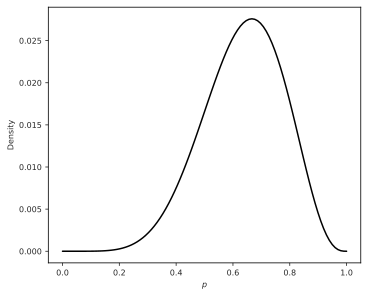

In [12]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(w, n, p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior /= np.sum(posterior)

plt.figure(figsize=(5,4))
plt.plot(p_grid, posterior)
plt.xlabel(r"$p$")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

#### Gaussian Model of Height

Let’s build a linear regression model now. Well, it’ll be a “regression” once we have a predictor variable in it. For now, we’ll get the scaffold in place and construct the predictor variable in the next section. For the moment, we want a single measurement variable to model as a Gaussian distribution. There will be two parameters describing the distribution’s shape, the mean $μ$ and the standard deviation $σ$. Bayesian updating will allow us to consider every possible combination of values for $μ$ and $σ$ and to score each combination by its relative plausibility, in light of the data. These relative plausibilities are the posterior probabilities of each combination of values $μ$, $σ$.

Another way to say the above is this. There are an infinite number of possible Gaussian distributions. Some have small means. Others have large means. Some are wide, with a large $σ$. Others are narrow. We want our Bayesian machine to consider every possible distribution, each defined by a combination of $μ$ and $σ$, and rank them by posterior plausibility. Posterior plausibility provides a measure of the logical compatibility of each possible distribution with the data and model.

In practice we’ll use approximations to the formal analysis. So we won’t really consider every possible value of μand σ. But that won’t cost us anything in most cases. Instead the thing to worry about is keeping in mind that the “estimate” here will be the entire posterior distribution, not any point within it. And as a result, the posterior distribution will be a distribution of Gaussian distributions. Yes, a distribution of distributions.

##### The Data

The data contained in `data\Howell1.csv` are partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s. For the non-anthropologists reading along, the !Kung San are the most famous foraging population of the twentieth century, largely because of detailed quantitative studies by people like Howell. Load the data and place them into a convenient object with:

In [13]:
d = pd.read_csv("data/Howell1.csv", sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


We can also use Arviz’s `summary` function, which we’ll also use to summarize posterior distributions later on:

In [14]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


Each column has 544 entries, so there are 544 individuals in these data. Each individual has a recorded height (centimeters), weight (kilograms), age (years), and “maleness” (0 indicating female and 1 indicating male).

We’re going to work with just the `height` column, for the moment. 

In [15]:
d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

All we want for now are heights of adults in the sample. The reason to filter out non-adults for now is that height is strongly correlated with age, before adulthood. Later, we’ll tackle the age problem. But for now, better to postpone it. You can filter the data frame down to individuals of age 18 or greater with:

In [16]:
d2 = d[d['age'] >= 18]

We’ll be working with the data frame d2 now. It should have 352 rows (individuals) in it.

##### The Model

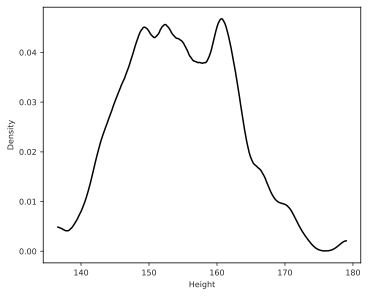

In [17]:
plt.figure(figsize=(5,4))
bw = utils.bw_nrd0(d2['height'].to_numpy())
az.plot_kde(d2['height'].to_numpy(), bw=bw*0.5)
plt.xlabel("Height")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

Our goal is to model these values using a Gaussian distribution. Plotting the density of the height, we see that it look rather Gaussian in shape, as is typical of height data. This may be because height is a sum of many small growth factors. As we saw earlier, a distribution of sums tends to converge to a Gaussian distribution. Whatever the reason, adult heights from a single population are nearly always approximately normal.

So it’s reasonable for the moment to adopt the stance that the model should use a Gaussian distribution for the probability distribution of the data. But be careful about choosing the Gaussian distribution only when the plotted outcome variable looks Gaussian to you. Gawking at the raw data, to try to decide how to model them, is usually not a good idea. The data could be a mixture of different Gaussian distributions, for example, and in that case you won’t be able to detect the underlying normality just by eyeballing the outcome distribution. Furthermore, as mentioned earlier, the empirical distribution needn’t be actually Gaussian in order to justify using a Gaussian probability distribution. 

So which Gaussian distribution? There are an infinite number of them, with an infinite number of different means and standard deviations. We’re ready to write down the general model and compute the plausibility of each combination of $μ$ and $σ$. To define the heights as normally distributed with a mean $μ$ and standard deviation $σ$, we write:

$$h_{i} \sim \text{Normal}(\mu, \sigma)$$

In many books you'll see the same model written as $h_{i} \sim \mathcal{N}(\mu, \sigma)$, which means the same thing. The symbol $h$ refers to the list of heights, and the subscript $i$ means each individual element of this list. It is conventional to use $i$ because it stands for index. The index $i$ takes on row numbers, and so in this example can take any value from 1 to 352 (the number of heights in `d2['height']`). As such, the model above is saying that all the model knows about each height measurement is defined by the same normal distribution, with mean $μ$ and standard deviation $σ$. Before long, those little $i$’s are going to show up on the right-hand side of the model definition, and you’ll be able to see why we must bother with them. So don’t ignore the $i$, even if it seems like useless ornamentation right now.

**Independent and identically distributed**. The short model above assumes that the values $h_i$ are *independent and identically distributed*, abbreviated i.i.d., iid, or IID. You might even see the same model written:

$$h_{i} \stackrel{iid}{\sim} \text{Normal}(\mu, \sigma)$$

“iid” indicates that each value $h_i$ has the same probability function, independent of the other $h$ values and using the same parameters. A moment’s reflection tells us that this is often untrue. For example, heights within families are correlated because of alleles shared through recent shared ancestry. 

The i.i.d. assumption doesn’t have to seem awkward, as long as you remember that probability is inside the model, not outside in the world. The i.i.d. assumption is about how the model represents its uncertainty. It is an epistemological assumption. It is not a physical assumption about the world, an ontological one. E. T. Jaynes (1922–1998) called this the *mind projection fallacy*, the mistake of confusing epistemological claims with ontological claims. The point isn’t that epistemology trumps reality, but that in ignorance of such correlations the best distribution may be i.i.d. This issue will return later. Furthermore, there is a mathematical result known as *de Finetti’s theorem* that
says values which are **exchangeable** can be approximated by mixtures of i.i.d. distributions. Colloquially, exchangeable values can be reordered. The practical impact is that “i.i.d.” cannot be read literally. There are also types of correlation that do little to the overall shape of a distribution, only affecting the sequence in which values appear. For example, pairs of sisters have highly correlated heights. But the overall distribution of female height remains normal. Markov chain Monte Carlo exploits this, using highly correlated sequential samples to estimate most any distribution
we like.

To complete the model, we’re going to need some priors. The parameters to be estimated are both $μ$ and $σ$, so we need a prior $Pr(μ,σ)$, the **joint prior probability for all parameters**. In most cases, priors are specified independently for each parameter, which amounts to assuming $Pr(μ,σ)=Pr(μ)Pr(σ)$. Then we can write:

$$\begin{align*}
h_{i} &\sim \text{Normal}(\mu, \sigma)\tag{Likelihood}\\
\mu &\sim \text{Normal}(178,20)\tag{μ prior} \\
\sigma &\sim \text{Uniform}(0,50)\tag{σ prior} \\
\end{align*}$$

The prior for $μ$ is a broad Gaussian prior, centered on 178 cm, with 95% of probability between 178 ± 40 cm.

Why 178 cm? Your author is 178 cm tall. And the range from 138 cm to 218 cm encompasses a huge range of plausible mean heights for human populations. So domain-specific information has gone into this prior. Everyone knows something about human height and can set a reasonable and vague prior of this kind. But in many regression problems, as you’ll see later, using prior information is more subtle, because parameters don’t always have such clear physical meaning.

Whatever the prior, it’s a very good idea to plot your priors, so you have a sense of the assumption they build into the model. In this case:

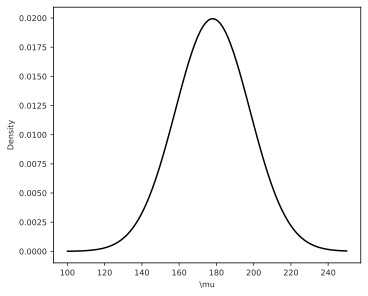

In [18]:
x = np.linspace(100, 250, 100)
plt.figure(figsize=(5,4))
plt.plot(x, stats.norm.pdf(x, loc=178, scale=20))
plt.xlabel(r"\mu")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

Execute that code yourself, to see that the model is assuming that the average height (not each individual height) is almost certainly between 140 cm and 220 cm. So this prior carries a little information, but not a lot. The $σ$ prior is a truly flat prior, a uniform one, that functions just to constrain $σ$ to have positive probability between zero and 50 cm. View it with:

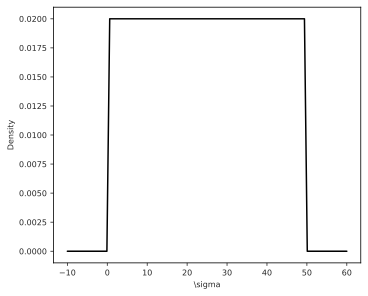

In [19]:
x = np.linspace(-10, 60, 100)
plt.figure(figsize=(5,4))
plt.plot(x, stats.uniform.pdf(x, loc=0, scale=50))
plt.xlabel(r"\sigma")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

A standard deviation like $σ$ must be positive, so bounding it at zero makes sense. How should we pick the upper bound? In this case, a standard deviation of 50 cm would imply that 95% of individual heights lie within 100 cm of the average height. That’s a very large range.

All this talk is nice. But it’ll help to see what these priors imply about the distribution of individual heights. The **prior predictive** simulation is an essential part of your modeling. Once you’ve chosen priors for $h$, $μ$, and $σ$, these imply a **joint prior distribution** of individual heights. By simulating from this distribution, you can see what your choices imply about observable height. This helps you diagnose bad choices. Lots of conventional choices are indeed bad ones, and we’ll be able to see this through prior predictive simulations.

Okay, so how to do this? You can quickly simulate heights by sampling from the prior, like you sampled from the posterior. Remember, every posterior is also potentially a prior for a subsequent analysis, so you can process priors just like posteriors.

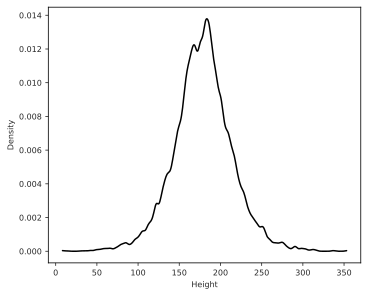

In [20]:
n_samples = int(1e4)
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

plt.figure(figsize=(5,4))

bw = utils.bw_nrd0(prior_h)
az.plot_kde(prior_h, bw=bw*0.5)
plt.xlabel("Height")
plt.ylabel("Density")
plt.gca().spines[['right', 'top']].set_visible(True);

The plot displays a vaguely bell-shaped density with thick tails. It is the **expected distribution of heights, averaged over the prior**. Notice that the **prior probability distribution** of height is not itself Gaussian. This is okay. The distribution you see is not an **empirical expectation**, but rather the **distribution of relative plausibilities** of different heights, before seeing the data.

Prior predictive simulation is very useful for assigning sensible priors, because it can be quite hard to anticipate how priors influence the observable variables. As an example, consider a much flatter and less informative prior for $μ$, like $μ \sim \text{Normal}(178,100)$. Priors with such large standard deviations are quite common in Bayesian models, but they are hardly ever sensible. Let’s use simulation again to see the implied heights:

In [21]:
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h_2 = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
bw_2 = utils.bw_nrd0(prior_h_2)

pct_neg_height = (prior_h_2[prior_h_2 < 0]).shape[0]/(prior_h_2).shape[0]
pct_giant_height = (prior_h_2[prior_h_2 > 272]).shape[0]/(prior_h_2).shape[0]
print('Model expectation of negative height:', pct_neg_height)
print('Model expectation of giants:', pct_giant_height)

Model expectation of negative height: 0.0431
Model expectation of giants: 0.185


Now the model, before seeing the data, expects 4% of people, those left of the dashed line, to have negative height. It also expects some giants. One of the tallest people in recorded history, Robert Pershing Wadlow (1918–1940) stood 272 cm tall. In our prior predictive simulation, 19% of people (right of solid line) are taller than this.

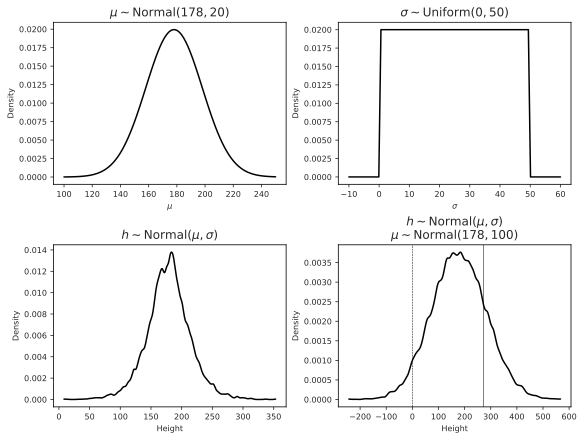

In [22]:
fig, axs = plt.subplots(2,2, figsize=(8, 6))

x = np.linspace(100, 250, 100)
axs[0][0].plot(x, stats.norm.pdf(x, loc=178, scale=20))
axs[0][0].set(xlabel=r"$\mu$", ylabel='Density', title=r'$\mu \sim \text{Normal}(178,20)$')

x = np.linspace(-10, 60, 100)
axs[0][1].plot(x, stats.uniform.pdf(x, loc=0, scale=50))
axs[0][1].set(xlabel=r"$\sigma$", ylabel='Density', title=r'$\sigma \sim \text{Uniform}(0,50)$')

az.plot_kde(prior_h, bw=bw*0.5, ax=axs[1][0])
axs[1][0].set(xlabel=r"Height", ylabel='Density', title=r'$h \sim \text{Normal}(\mu,\sigma)$')

az.plot_kde(prior_h_2, bw=bw_2*0.5, ax=axs[1][1])
axs[1][1].axvline(0, linewidth=0.5, linestyle='--', color='k')
axs[1][1].axvline(272, linewidth=0.5, linestyle='-', color='k')
axs[1][1].set(xlabel=r"Height", ylabel='Density', title='$h \sim \\text{Normal}(\mu,\sigma)$\n$\mu \sim \\text{Normal}(178,100)$')

for ax in axs.flatten():
    ax.spines[['right', 'top']].set_visible(True);

Prior predictive simulation for the height model. Top row: Prior distributions for μand σ. Bottom left: The prior predictive simulation for height, using the priors in the top row. Values at 3 standard deviations shown on horizontal axis. Bottom right: Prior predictive simulation using $μ \sim \text{Normal}(178,100)$.

Does this matter? In this case, we have so much data that the silly prior is harmless. But that won’t always be the case. There are plenty of inference problems for which the data alone are not sufficient, no matter how numerous. Bayes lets us proceed in these cases. But only if we use our scientific knowledge to construct sensible priors. Using scientific knowledge to build priors is not cheating. The important thing is that your prior not be based on the values in the data, but only on what you know about the data before you see it.

**Model definition to Bayes’ theorem**. It can help to see how the model definition from earlier allows us to build up the posterior distribution. The height model, with its priors for $μ$ and $σ$, defines this posterior distribution:

$$Pr(\mu, \sigma \mid h) = \frac{\prod_{i} \text{Normal}(h_i\mid \mu, \sigma)\text{Normal}(\mu \mid 178, 20) \text{Uniform}(\sigma\mid0,50)}{\int \int \prod_i \text{Normal}(h_i\mid \mu, \sigma)\text{Normal}(\mu \mid 178, 20) \text{Uniform}(\sigma\mid0,50)d\mu d\sigma}$$

This looks monstrous, but it’s the same creature as before. There are two new things that make it seem complicated. The first is that there is more than one observation in $h$, so to get the **joint likelihood across all the data**, we have to compute the probability for each $h_i$ and then **multiply all these likelihoods together**. The product on the right-hand side takes care of that. The second complication is the two priors, one for $μ$ and one for $σ$. But these just stack up. In the grid approximation code in the section to follow, you’ll see the implications of this definition in the Python code. Everything will be calculated on the log scale, so multiplication will become addition. But otherwise it’s just a matter of executing Bayes’ theorem.

##### Grid Approximation of the Posterior Distribution

Since this is the first Gaussian model in the book, and indeed the first model with more than one parameter, it’s worth quickly mapping out the posterior distribution through brute force calculations. This isn’t the approach I encourage in any other place, because it is laborious and computationally expensive. Indeed, it is usually so impractical as to be essentially impossible. But as always, it is worth knowing what the target actually looks like, before you start accepting approximations of it. A little later, we’ll use quadratic approximation to estimate the posterior distribution, and that’s the approach we will use for several notebooks. Once you have the samples you’ll produce in this subsection, you can compare them to the quadratic approximation in the next.

Unfortunately, doing the calculations here requires some technical tricks that add little, if any, conceptual insight. Here is the model:

In [99]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)


In [97]:
mu_list, sigma_list = np.meshgrid(
    np.linspace(150, 160, 100), 
    np.linspace(7, 9, 100))

post = np.append(sigma_list, sigma_list).reshape(2,-1).T

likelihood = np.sum(
    stats.norm.logpdf(
        d2['height'], 
        loc=mu_list.reshape(-1,1), 
        scale=sigma_list.reshape(-1,1)), 
    axis=1)

post_prod = (
    likelihood.reshape(-1,1)
    + stats.norm.logpdf(mu_list.reshape(-1,1), loc=178, scale=20)
    + stats.uniform.logpdf(sigma_list.reshape(-1,1), loc=0, scale=50)
)


array([[-1307.83698942],
       [-1304.53082031],
       [-1301.29797202],
       ...,
       [-1293.78191245],
       [-1296.08246662],
       [-1298.42738543]])